In [2]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,data.table,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

## Read in metadata-linked abundances from `process-abundance-data.ipynb`

In [3]:
sam_with_meta_bact <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact.csv")))
sam_with_meta <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk.csv")))
data_tree_bact <- data.frame(fread(file.path("..","..","data","data_tree_bact.csv")))
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))
abundance_df <- data.frame(fread(file.path("..","..","data","abundance_df_euk.csv")))

In [8]:
colnames(sam_with_meta)

[1] "V1"                                       
 [2] "X.rname"                                  
 [3] "startpos"                                 
 [4] "endpos"                                   
 [5] "numreads"                                 
 [6] "covbases"                                 
 [7] "coverage"                                 
 [8] "meandepth"                                
 [9] "meanbaseq"                                
[10] "meanmapq"                                 
[11] "TPM"                                      
[12] "Sample"                                   
[13] "AssemblyName"                             
[14] "X.x"                                      
[15] "totalreads"                               
[16] "propreads"                                
[17] "X.y"                                      
[18] "AnalysisIDs"                              
[19] "Assembly"                                 
[20] "Raw"                                      
[21] "SeqProjID"                                
[22] "Analysis.Project.GOLD.Analysis.Project.ID"
[23] "Analysis.Project.Analysis.Project.Name"   
[24] "Analysis.Project.Analysis.Project.Type"   
[25] "Analysis.Project.IMG.Submission.ID"       
[26] "Analysis.Project.Assembly.Method"         
[27] "Analysis.Project.Add.Date"                
[28] "Analysis.Project.IMG.Taxon.ID"            
[29] "Analysis.Project.ITS.Analysis.Project.ID" 
[30] "SampleDate"                               
[31] "type"                                     
[32] "clustnum"                                 
[33] "seqlen"                                   
[34] "percid"                                   
[35] "plus"                                     
[36] "a"                                        
[37] "b"                                        
[38] "aln"                                      
[39] "target"                                   
[40] "Label"

In [5]:
data_tree_euk %>% dplyr::filter(label=="Ga0453066_0002957SSU_rRNA_eukarya") %>%
    dplyr::select(qseqid,Label,Lineage,percid,Label,seqlen,clustnum)

qseqid,Label,Lineage,percid,seqlen,clustnum
<chr>,<chr>,<chr>,<chr>,<int>,<int>
Ga0453066_0002957SSU_rRNA_eukarya,MEND-TF-18S-78,cellular organisms; Eukaryota; Cryptophyceae; Pyrenomonadales; Geminigeraceae; Teleaulax,*,1837,-78


In [6]:
distinct_cols <- c('#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
                   '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
                   '#9a6324', '#fffac8', '#800000', '#aaffc3', 
                   '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000')

## Functions for use downstream

In [10]:
getOurSeason <- function(date) {
    d <- as.POSIXlt(date, format="%d%b%Y")
    if (is.na(date) ) {
        return("")
    }
    if (grepl("D",date) & !grepl("Dec",date)) {
        date = unlist(strsplit(date,"D"))[1]
    }
    if (grepl("Mendota",date)) {
        return("")
    }
    
    curr_year = format(as.Date(d,format="%d%b%Y"),"%Y")
    WS <- as.POSIXlt(paste0(as.character(curr_year),"-12-15"), format = "%Y-%m-%d") # Winter Solstice
    SE <- as.POSIXlt(paste0(as.character(curr_year),"-03-15"),  format = "%Y-%m-%d") # Spring Equinox
    SS <- as.POSIXlt(paste0(as.character(curr_year),"-06-15"),  format = "%Y-%m-%d") # Summer Solstice
    FE <- as.POSIXlt(paste0(as.character(curr_year),"-09-15"),  format = "%Y-%m-%d") # Fall Equinox

    if (is.na(d$yday) | is.na(WS$yday) | is.na(SE$yday) | is.na(FE$yday) | is.na(SS$yday)) {
        return("NoSeason")
    }
    if (((d$yday >= WS$yday) & (d$yday < SE$yday)) | (d$yday < SE$yday)) {
        return("Winter")
    } else if ((d$yday >= SE$yday) & (d$yday < SS$yday)) {
        return("Spring")
    } else if ((d$yday >= SS$yday) & (d$yday < FE$yday)) {
        return("Summer")
    } else {
        return("Fall")
    }
}

seasonal_info=read.csv("../../data/season_dates.csv",comment="#") %>%
    dplyr::mutate(StartDate=as.Date(StartDate,origin="1970-01-01",format="%Y-%m-%d"),
                  EndDate=as.Date(EndDate,origin="1970-01-01",format="%Y-%m-%d"))
get_season_from_date <- function(date_vect) {
    season_list = c()
    for (date_curr in date_vect) {
        selected_season = seasonal_info %>% dplyr::filter((StartDate <= date_curr)&(EndDate >= date_curr))
        if (length(selected_season)==0) {
            season_list = c(season_list,"Missing")
        } else {
            if (length(selected_season$Season) > 1) {
                print("YO what gives")
                print(selected_season$Season)
            }
            season_list = c(season_list,as.character(selected_season$Season))
        }
    }
    return(season_list)
}

make_heatmap_df <- function(sam_with_meta,data_tree_euk) {
    heatmap_df = sam_with_meta %>% 
        dplyr::left_join(data_tree_euk %>% dplyr::select(label),
                         by = c("X.rname"= "label")) %>%
        dplyr::mutate(Season = unlist(lapply(SampleDate, get_season_from_date))) %>%
        group_by(X.rname) %>% dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
        group_by(X.rname,Season) %>% 
        dplyr::summarize(MeanZScore = mean(ZScore))
    return(heatmap_df)
}
curr_cm="RF01960"

for_plotting = sam_with_meta %>% dplyr::inner_join(data_tree_euk, by = c("X.rname" = "label","Label"))

means_within_seasons = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order)) %>%
    dplyr::mutate(FormattedDate=as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")) %>%
    dplyr::full_join(seasonal_info,by=c("Year")) %>%
    dplyr::filter((FormattedDate >= StartDate) & (FormattedDate <= EndDate))

total_in_season = means_within_seasons %>% 
    dplyr::distinct(Season,Year,FormattedDate) %>%
    dplyr::group_by(Season,Year) %>%
    dplyr::tally()

means_with_seasons_ = means_within_seasons %>% 
    dplyr::left_join(total_in_season) %>%
    dplyr::mutate(Weights = 1 / n) %>%
    dplyr::group_by(Season,Label) %>%
    dplyr::summarize(meanTPM = sum(TPM*Weights) / sum(Weights),
                     sdTPM = sqrt((sum(((TPM-sum(TPM*Weights) / sum(Weights))^2)*Weights) / 
                          (sum(Weights)*(length(Weights)-1)/length(Weights)))))

Joining, by = c("Year",
"Season")
`summarise()` has grouped
output by 'Season'. You can
override using the
`.groups` argument.


## Read in tree file

In [22]:
folder_stub = file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                        "refseq-DIAMOND", "tree-builder", "2021-12-20_eukaryota")

tree_file_euk <- read.tree(file.path(folder_stub,"iqtree_select",
                                     "total_tree_RF01960.treefile"))
rooted.tree <- tree_file_euk

split_labs = c()
for (curr_lab in tree_file_euk$tip.label) {
    if (grepl("\\|", curr_lab)) {
        split_labs = c(split_labs,unlist(strsplit(curr_lab, "\\|"))[2])
    } else {
        split_labs = c(split_labs,unlist(strsplit(curr_lab, "\\|"))[1])
    }
}
tree_file_euk$tip.label = split_labs

In [23]:
heatmap_df = sam_with_meta %>% 
    dplyr::left_join(data_tree_euk %>% dplyr::select(label),
                     by = c("X.rname"= "label")) %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::full_join(seasonal_info,by=c("Year")) %>%
    dplyr::left_join(total_in_season) %>%
    dplyr::mutate(Weights = 1 / n) %>%
    dplyr::mutate(FormattedDate=as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))%>%
    dplyr::filter((FormattedDate >= StartDate) & (FormattedDate <= EndDate)) %>%
    dplyr::left_join(means_with_seasons_,by=c("Season","Label")) %>%
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - meanTPM) / sdTPM) %>%
    #group_by(X.rname) %>% dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    group_by(X.rname,Season) %>% 
    dplyr::summarize(MeanZScore = mean(ZScore))

Joining, by = c("Year",
"Season")
`summarise()` has grouped
output by 'X.rname'. You
can override using the
`.groups` argument.


In [28]:
data_tree_euk_mod <- data_tree_euk # we already modified in `process-abundance-data`
data_tree_euk_mod$Phylum[((data_tree_euk_mod$isTip) & is.na(data_tree_euk$Phylum)) | (grepl("Bacteria",data_tree_euk$Domain)) ] = "Bacterial"
data_tree_euk_mod = data_tree_euk_mod %>% dplyr::mutate(x = dplyr::case_when(x > 4 ~ x - 4,
                                                            TRUE ~ x))
data_tree_euk_mod$Metagenome[data_tree_euk_mod$Phylum == "Bacterial"] = "Outgroup"
p2 <- ggtree(data_tree_euk_mod,branch.length = "branch.length",layout="circular") + 
    xlim(0,NA) + #-0.05, NA) +
    #data_tree_euk,branch.length = "branch.length",layout="circular",aes(fill = Phylum)) + 
    #%>% collapse(node = 164) +
    scale_x_continuous(expand=c(0, 0.7)) +
    geom_tippoint(data = data_tree_euk_mod, 
                  aes(shape = Metagenome,y = y,fill = trimws(Phylum)),size=2,color="black",alpha=0.5) + 
    scale_shape_manual(values=c(21,23,24)) + 
      geom_fruit(
          data=abundance_df,
          geom=geom_bar,
          mapping=aes(y=X.rname, x=NumberHighAbund, fill=trimws(PhylumNew)),  #The 'Abundance' of 'dat1' will be mapped to x
          pwidth=0.4,
          stat="identity",
          orientation="y", # the orientation of axis.
          axis.params=list(
                          axis="x", # add axis text of the layer.
                          text.angle=-45, # the text size of axis.
                          hjust=0  # adjust the horizontal position of text of axis.
                      ),
          grid.params=list() # add the grid line of the external bar plot.
      ) + scale_fill_manual(name="Taxonomic Group",values=c(distinct_cols),na.value="black") + 
      guides(fill=guide_legend(ncol=3))+
      new_scale_fill() + 
      geom_fruit(
          data=heatmap_df %>% dplyr::filter(Season != "") %>%
               dplyr::mutate(Season = factor(Season, levels = c("Spring","Summer","Fall","Winter"))),
          geom=geom_point,
          mapping=aes(y=X.rname, x=Season, fill=Season, size = MeanZScore),
          color = "grey50", offset = 0.04, shape = 21
      ) + scale_fill_manual(name="Season",
                            breaks = c("Spring","Summer","Fall","Winter"),
                            labels = c("Spring","Summer","Fall","Winter"),
                            values=c("pink","green","orange","blue"),na.value="black") + 
         scale_alpha_continuous(range=c(0, 1),
                             guide=guide_legend(keywidth = 0.3, 
                                             keyheight = 0.3, order=5), name = "Mean Z-Score") +
    geom_tiplab(data = data_tree_euk_mod, 
                aes(label = Label,angle=angle),size=1,offset = 0.1) 



Scale for x is already
present.
Adding another scale for x,
which will replace the
existing scale.
Warning message:
“The following column names/name: V1 are/is the same to tree data, the tree
data column names are : V1, label, y, angle, TipLab, qseqid, Lineage,
TopLevel, Domain, Phylum, Class, Order, Family, Genus, Group, Clade,
Subfamily, Species, Subphylum, Subclass, Suborder, Infraclass, Superorder,
Superfamily, type, clustnum, seqlen, percid, plus, a, b, aln, target, Label,
Metagenome.”


In [31]:
families_list = c("Coccidia","Ceratiaceae","Daphniidae","Cryptocaryon",
                  "Hexanauplia","Oligohymenophorea")
families_list = c("Strobilidiidae",
                  #"Eucoccidiorida",
                  "Ceratiaceae","Daphniidae",
                  "Cryptomonadaceae",
                  #"Brachionidae",
                  "Protaspidae",
                  "Aulacoseiraceae")
phylum_list = c()#"Rotifera")
hilight_frame = data.frame()
for (curr_fam in families_list) {
    hilight_frame = hilight_frame %>%
        dplyr::bind_rows(data.frame("Nodes" = MRCA(ggtree(tree_file_euk), 
                                              (data_tree_euk_mod %>% dplyr::filter(grepl(curr_fam,Family)))$label),
               "Labels" = c(curr_fam),
               "Angles" = (data_tree_euk_mod %>% dplyr::filter(node == MRCA(ggtree(tree_file_euk),
                                                                            (data_tree_euk_mod %>% 
                                                                             dplyr::filter(grepl(curr_fam,Family)))$label)))$angle))
}

for (curr_phy in phylum_list) {
    hilight_frame = hilight_frame %>%
        dplyr::bind_rows(data.frame("Nodes" = MRCA(ggtree(tree_file_euk), 
                                              (data_tree_euk_mod %>% dplyr::filter(grepl(curr_phy,Phylum)))$label),
               "Labels" = c(curr_phy),
               "Angles" = (data_tree_euk_mod %>% dplyr::filter(node == MRCA(ggtree(tree_file_euk),
                                                                            (data_tree_euk_mod %>% 
                                                                             dplyr::filter(grepl(curr_fam,Phylum)))$label)))$angle))
}

In [32]:
data_tree_euk_mod %>% dplyr::filter(Phylum == "Cryptophyta") #%>%
    #dplyr::select(Phylum,Class,Order,Family)

V1,parent,node,branch.length,label,isTip,x,y,branch,angle,⋯,clustnum,seqlen,percid,plus,a,b,aln,target,Label,Metagenome
<int>,<int>,<int>,<dbl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4,203,4,0.0476890592,JQ434475.1,TRUE,1.698162,146,5.674317,276.63158,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Ref
5,203,5,0.1274788182,Ga0334984_0033414SSU_rRNA_eukarya,TRUE,1.777952,147,5.714212,278.52632,⋯,-237,1784,*,*,*,*,*,*,MEND-TF-18S-237,MG
6,205,6,0.0067819417,U53122.1,TRUE,1.717629,148,5.714238,280.42105,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Ref
7,205,7,0.0015072549,Ga0334996_0033214SSU_rRNA_eukarya,TRUE,1.712354,149,5.711600,282.31579,⋯,-250,1778,*,*,*,*,*,*,MEND-TF-18S-250,MG
8,210,8,0.0048230837,AF508267.1,TRUE,1.856580,157,5.854168,297.47368,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Ref
9,210,9,0.0063338789,Ga0453902_0021511SSU_rRNA_eukarya,TRUE,1.858090,158,5.854924,299.36842,⋯,-268,1771,*,*,*,*,*,*,MEND-TF-18S-268,MG
10,209,10,0.0284864724,Ga0453187_0014689SSU_rRNA_eukarya,TRUE,1.861362,156,5.847118,295.57895,⋯,-284,1765,*,*,*,*,*,*,MEND-TF-18S-284,MG
11,208,11,0.0013178512,Ga0453189_0017956SSU_rRNA_eukarya,TRUE,1.782516,155,5.781857,293.68421,⋯,-266,1771,*,*,*,*,*,*,MEND-TF-18S-266,MG
12,207,12,0.0212438239,AF508274.1,TRUE,1.753023,154,5.742401,291.78947,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Ref


In [10]:
data_tree_euk_mod %>% dplyr::filter(Phylum == "Ciliophora") %>%
    dplyr::select(Phylum,Class,Order,Family)

Phylum,Class,Order,Family
<chr>,<chr>,<chr>,<chr>
Ciliophora,Oligohymenophorea,Sessilida,Epistylidae
Ciliophora,Oligohymenophorea,Sessilida,Epistylidae
Ciliophora,Oligohymenophorea,Sessilida,Zoothamniidae
Ciliophora,Oligohymenophorea,Sessilida,Epistylidae
Ciliophora,Oligohymenophorea,Sessilida,Epistylidae
Ciliophora,Oligohymenophorea,Sessilida,Zoothamniidae
Ciliophora,Oligohymenophorea,Sessilida,Vorticellidae
Ciliophora,Oligohymenophorea,Sessilida,Vorticellidae
Ciliophora,Oligohymenophorea,Sessilida,Vorticellidae


In [26]:
phylum_legend_entries <- sort(unique(data_tree_euk_mod$Phylum))
phylum_legend_entries

[1] "Alveolata"       "Apicomplexa"     "Arthropoda"      "Ascomycota"     
 [5] "Bacterial"       "Bigyra"          "Cercozoa"        "Chlorophyta"    
 [9] "Chytridiomycota" "Ciliophora"      "Cryptophyta"     "Endomyxa"       
[13] "Euglenozoa"      "Haptophyta"      "Mollusca"        "Ochrophyta"     
[17] "Oomycota"        "Opisthokonta"    "Rotifera"        "Stramenopiles"

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message:
“The following column names/name: V1 are/is the same to tree data, the tree
data column names are : V1, label, y, angle, TipLab, qseqid, Lineage,
TopLevel, Domain, Phylum, Class, Order, Family, Genus, Group, Clade,
Subfamily, Species, Subphylum, Subclass, Suborder, Infraclass, Superorder,
Superfamily, type, clustnum, seqlen, percid, plus, a, b, aln, target, Label,
Metagenome, xmaxtmp.”
Warning message:
“Removed 110 rows containing missing values (geom_tile).”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 110 rows containing missing values (geom_tile).”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


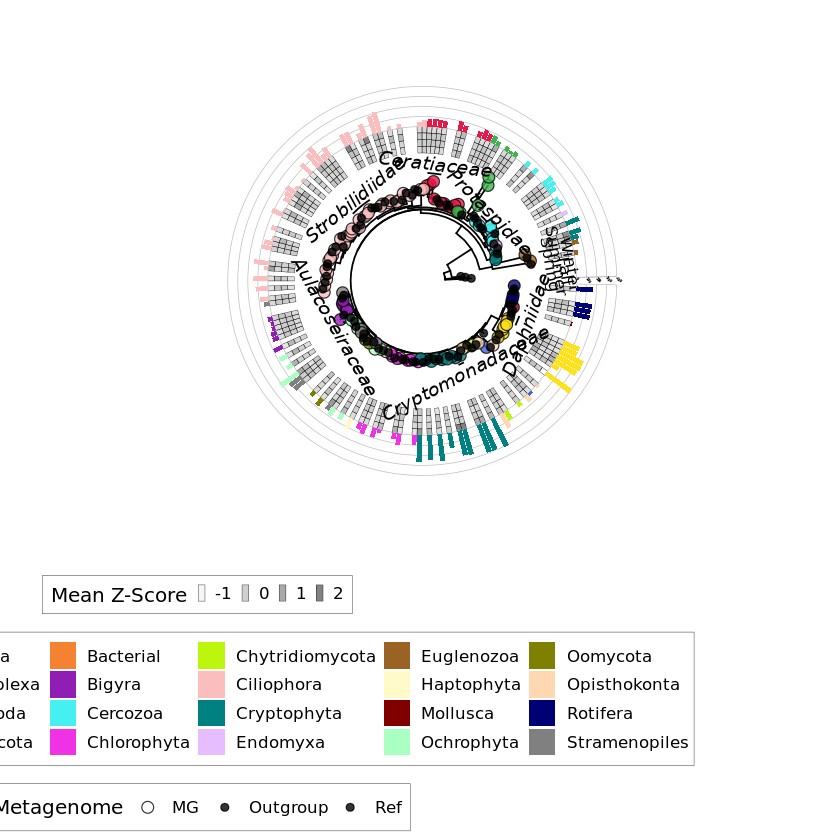

In [110]:
## clean fig for MS
p2 <- ggtree(data_tree_euk_mod,branch.length = "branch.length",layout="circular") + 
    xlim(0,NA) + 
    scale_x_continuous(expand=c(0, 0.7)) +
    geom_tippoint(data = data_tree_euk_mod, 
                  aes(shape = Metagenome,y = y,fill = trimws(Phylum)),size=3,color="black",alpha=0.8) + 
    scale_shape_manual(values=c(21,20,20),#values=c(21,23,24),
                       breaks=c("MG","Outgroup","Ref")) + 
    scale_fill_manual(name="Taxonomic Group",breaks=phylum_legend_entries,
                      values=c(distinct_cols),na.value="black") + 
      guides(fill=guide_legend(ncol=3))+
      geom_fruit(
          data=heatmap_df %>% dplyr::filter(Season != "") %>%
               dplyr::mutate(Season = factor(Season, levels = c("Spring","Summer","Fall","Winter"))),
          geom=geom_tile,
          mapping=aes(y=X.rname, x=Season, alpha = MeanZScore),
          color = "black", fill="grey50", offset = 0.04,
          axis.params = list(axis = "x", text.angle = 280, text.size = 3.5, vjust=0.5,hjust=0.75)
      ) + 
      geom_fruit(
          data=abundance_df,
          geom=geom_bar,
          mapping=aes(y=X.rname, x=NumberHighAbund, fill=trimws(PhylumNew)),  #The 'Abundance' of 'dat1' will be mapped to x
          pwidth=0.4,
          stat="identity",
          orientation="y", # the orientation of axis.
          axis.params=list(
                          axis="x", # add axis text of the layer.
                          text.angle=-45, # the text size of axis.
                          hjust=0  # adjust the horizontal position of text of axis.
                      ),
          grid.params=list() # add the grid line of the external bar plot.
      )+
         scale_alpha_continuous(range=c(0, 1),
                             guide=guide_legend(keywidth = 0.3, 
                                             keyheight = 0.3, order=5), name = "Mean Z-Score") 

clade_labels = apply(hilight_frame, 1, function(x) {
    list(geom_cladelabel(node=x[["Nodes"]],
                         label=x[["Labels"]],
                         angle = x[["Angles"]]))
})

p2 + new_scale_fill() + #geom_hilight(data=hilight_frame, extendto=4, aes(node= Nodes, fill = Labels)) + 
 geom_cladelab(data=hilight_frame, 
               mapping=aes(node=Nodes, 
                           label=Labels),
               hjust=0.5,
               angle="auto",
               horizontal=FALSE, 
               offset=0.2,
               offset.text=0.27,
               fontsize=4,
               fontface="italic"
               )+
  guides(fill=guide_legend(ncol=2))+
  theme(legend.justification=c(1,-0.2),
        legend.text=element_text(size=10),
        legend.title=element_text(size=12),
        axis.title.x=element_text(size=10),
        axis.title.y=element_text(size = 10),
        legend.key = element_blank(),
        legend.background = element_rect(color="black",size = 0.1),
        legend.box = "vertical", 
        legend.position = "bottom") + guides(fill=guide_legend(nrow=2,byrow=TRUE))
ggsave(file.path("..","..","figures","eukaryotic_tree.pdf"),width=15,height=15,units="in",dpi=400)

Scale for x is already
present.
Adding another scale for x,
which will replace the
existing scale.
Warning message:
“The following column names/name: V1 are/is the same to tree data, the tree
data column names are : V1, label, y, angle, TipLab, qseqid, Lineage,
TopLevel, Domain, Phylum, Class, Order, Family, Genus, Group, Clade,
Subfamily, Species, Subphylum, Subclass, Suborder, Infraclass, Superorder,
Superfamily, type, clustnum, seqlen, percid, plus, a, b, aln, target, Label,
Metagenome, xmaxtmp.”


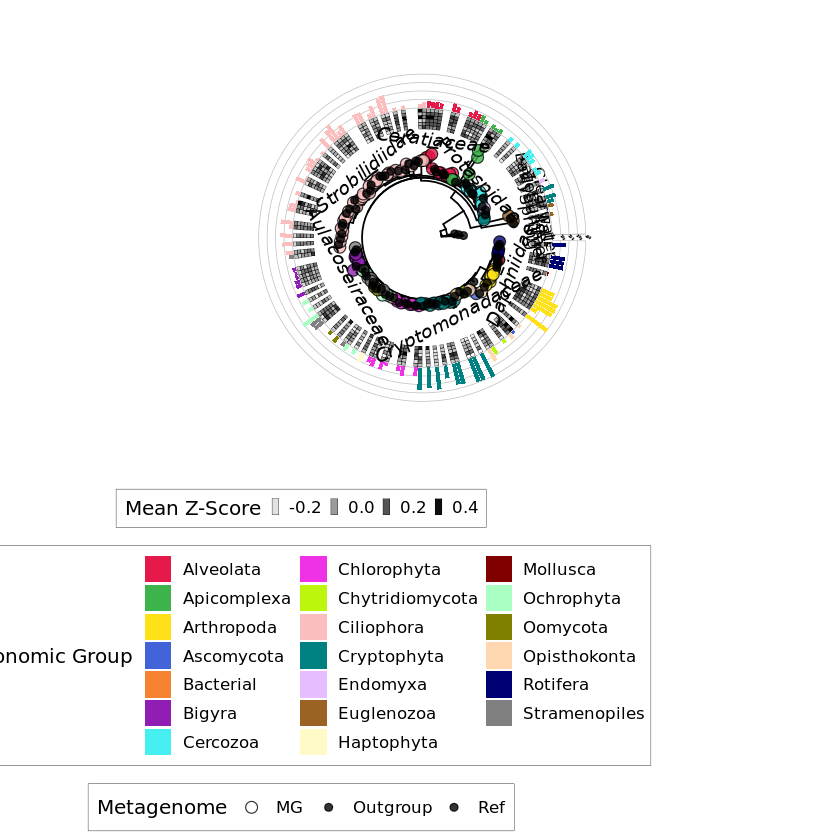

In [36]:
#+ 
#    scale_fill_manual(name="Season",
#                            breaks = c('Spring','LateSummer','EarlySummer','Ice','Fall','Clearwater'),
#                            labels = c('Spring','Late summer','Early summer','Ice','Fall','Clearwater'),
#                           values=c("pink","#6B9E17","#A2C655","#c2e0f9","#e09f3e","#f5fcff"),na.value="black")

## clean fig for MS
p2 <- ggtree(data_tree_euk_mod,branch.length = "branch.length",layout="circular") + 
    xlim(0,NA) + 
    scale_x_continuous(expand=c(0, 0.7)) +
    geom_tippoint(data = data_tree_euk_mod, 
                  aes(shape = Metagenome,y = y,fill = trimws(Phylum)),size=3,color="black",alpha=0.8) + 
    scale_shape_manual(values=c(21,20,20),#values=c(21,23,24),
                       breaks=c("MG","Outgroup","Ref")) + 
    scale_fill_manual(name="Taxonomic Group",breaks=phylum_legend_entries,
                      values=c(distinct_cols),na.value="black") + 
      guides(fill=guide_legend(ncol=3))+
      geom_fruit(
          data=heatmap_df %>% dplyr::filter(Season != "") %>%
               dplyr::mutate(Season = factor(Season, levels = c('Spring','EarlySummer','LateSummer',
                                                                'Ice','Fall','Clearwater'))),
          geom=geom_tile,
          mapping=aes(y=X.rname, x=Season, alpha = MeanZScore),
          color = "black", fill="black", offset = 0.04,
          axis.params = list(axis = "x", text.angle = 280, text.size = 3.5, vjust=0.5,hjust=0.75)
      ) + 
      geom_fruit(
          data=abundance_df,
          geom=geom_bar,
          mapping=aes(y=X.rname, x=NumberHighAbund, fill=trimws(PhylumNew)),  #The 'Abundance' of 'dat1' will be mapped to x
          pwidth=0.4,
          stat="identity",
          orientation="y", # the orientation of axis.
          axis.params=list(
                          axis="x", # add axis text of the layer.
                          text.angle=-45, # the text size of axis.
                          hjust=0  # adjust the horizontal position of text of axis.
                      ),
          grid.params=list() # add the grid line of the external bar plot.
      )+
         scale_alpha_continuous(range=c(0, 1),
                             guide=guide_legend(keywidth = 0.3, 
                                             keyheight = 0.3, order=5), name = "Mean Z-Score") 

clade_labels = apply(hilight_frame, 1, function(x) {
    list(geom_cladelabel(node=x[["Nodes"]],
                         label=x[["Labels"]],
                         angle = x[["Angles"]]))
})

p2 + new_scale_fill() + #geom_hilight(data=hilight_frame, extendto=4, aes(node= Nodes, fill = Labels)) + 
 geom_cladelab(data=hilight_frame, 
               mapping=aes(node=Nodes, 
                           label=Labels),
               hjust=0.5,
               angle="auto",
               horizontal=FALSE, 
               offset=0.2,
               offset.text=0.27,
               fontsize=4,
               fontface="italic"
               )+
  guides(fill=guide_legend(ncol=2))+
  theme(legend.justification=c(1,-0.2),
        legend.text=element_text(size=10),
        legend.title=element_text(size=12),
        axis.title.x=element_text(size=10),
        axis.title.y=element_text(size = 10),
        legend.key = element_blank(),
        legend.background = element_rect(color="black",size = 0.1),
        legend.box = "vertical", 
        legend.position = "bottom") + guides(fill=guide_legend(nrow=2,byrow=TRUE))
ggsave(file.path("..","..","figures","eukaryotic_tree.pdf"),width=15,height=15,units="in",dpi=400)